# **S&P 500 Financial Forecasting with LSTMs**

In [112]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Pre-Processing

In [113]:
df = pd.read_csv("/kaggle/input/sandp500/all_stocks_5yr.csv")

df.head(3)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL


In [114]:
df = df.tail(15000)

In [115]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [116]:
print(len(df))

15000


In [117]:
df['date'] = pd.to_datetime(df['date'])

In [118]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 604040 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15000 non-null  datetime64[ns]
 1   open    15000 non-null  float64       
 2   high    15000 non-null  float64       
 3   low     15000 non-null  float64       
 4   close   15000 non-null  float64       
 5   volume  15000 non-null  int64         
 6   Name    15000 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 820.4+ KB
None
             date   open    high     low  close  volume Name
604040 2013-07-16  72.24  72.710  71.805  72.70  814949  XEC
604041 2013-07-17  72.70  73.440  72.560  72.90  547884  XEC
604042 2013-07-18  73.26  74.530  72.975  74.53  810434  XEC
604043 2013-07-19  74.46  75.970  73.910  75.92  444283  XEC
604044 2013-07-22  75.62  75.904  74.550  74.86  521703  XEC


## Feature Engineering

### Goal:
* Create more features from the exsisitng features within this data so we have more relevant data the model can learn from

In [119]:
# Creation of Additional Features from existing features
df['price_change'] = df['close'] - df['open']
df['high_low_range'] = df['high'] - df['low']
df['volume_change'] = df['volume'].pct_change()

# Setting up Moving Averages (MA's)
df['ma5'] = df['close'].rolling(window=5).mean()
df['ma10'] = df['close'].rolling(window=10).mean()
df['ma20'] = df['close'].rolling(window=20).mean()

# Shifted features for superivsed learnning (e.g. predicting tomorrows close)
df['close_shifted'] = df['close'].shift(-1)

df.dropna(inplace=True)

In [120]:
# 1. Relative Strength Index (RSI)
def calculate_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['rsi_14'] = calculate_rsi(df['close'], 14)

# 2. Exponential Moving Average (EMA)
df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()

# 3. Moving Average Convergence Divergence (MACD)
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# 4. Bollinger Bands
df['bollinger_up'] = df['ma20'] + (df['close'].rolling(window=20).std() * 2)
df['bollinger_down'] = df['ma20'] - (df['close'].rolling(window=20).std() * 2)

# 5. Volume Weighted Average Price (VWAP)
df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

# 6. Lagged Features
df['close_lag1'] = df['close'].shift(1)
df['close_lag2'] = df['close'].shift(2)
df['close_lag5'] = df['close'].shift(5)

# 7. Temporal Features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

# 8. Interaction Features
df['price_volume_interaction'] = df['price_change'] * df['volume']
df['high_low_ratio'] = df['high'] / df['low']

In [121]:
prices = df['close'].values
prices = prices.reshape(-1, 1)

In [122]:
df.columns #new features pre-training

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name',
       'price_change', 'high_low_range', 'volume_change', 'ma5', 'ma10',
       'ma20', 'close_shifted', 'rsi_14', 'ema_12', 'ema_26', 'macd',
       'macd_signal', 'bollinger_up', 'bollinger_down', 'vwap', 'close_lag1',
       'close_lag2', 'close_lag5', 'day_of_week', 'month', 'quarter',
       'price_volume_interaction', 'high_low_ratio'],
      dtype='object')

### Normalizing the Pricing using MinMaxScaler (scaling the data between 0 and 1)

In [123]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

### Prepare Training Data

In [124]:
def createing_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

In [125]:
#Setting sequence length (i.e using past 60 days to predict the next day)
sequence_length = 60
X, y = createing_sequences(scaled_prices, sequence_length)

# Converting to PyTorch Tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

## **LSTM Model**

Initailziation and Training

In [126]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        
        # Defining the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        
        # Defining a fully connected layer for the output
        self.fc = nn.Linear(hidden_layer_size, output_size)
            
    def forward(self, x):
        batch_size = x.size(0)

        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(x.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(x.device))
        
        lstm_out, hidden_cell = self.lstm(x, hidden_cell)
        
        # Taking the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        
        # Passing the output through the fully connected layer
        predictions = self.fc(lstm_out)
        
        return predictions

### Training

In [127]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [128]:
# Initializing the model, loss function, and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Sending model to GPU
model = model.to(device)

# Sending data to GPU
X, y = X.to(device), y.to(device)


# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    
    # Clear the gradients
    optimizer.zero_grad()
    
    # Initialize hidden states for every epoch
    batch_size = X.size(0)
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    # Forward pass
    y_pred = model(X)
    
    # Compute the loss
    loss = loss_function(y_pred, y)
    
    # Backward pass
    loss.backward()
    
    # Updating the weights
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

Using device: cuda
Epoch 0 Loss: 0.10340049862861633
Epoch 10 Loss: 0.04071483761072159
Epoch 20 Loss: 0.031068187206983566
Epoch 30 Loss: 0.011179864406585693
Epoch 40 Loss: 0.007506240624934435
Epoch 50 Loss: 0.0030634691938757896
Epoch 60 Loss: 0.001417033839970827
Epoch 70 Loss: 0.0008199962903745472
Epoch 80 Loss: 0.0006473316461779177
Epoch 90 Loss: 0.0005878559895791113


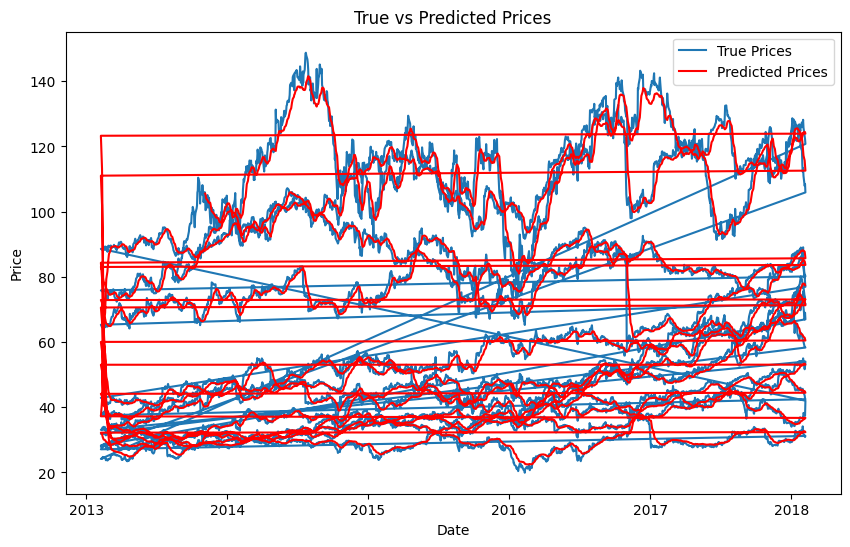

In [129]:
# Setting the model to evaluation mode
model.eval()

# Generating predictions
with torch.no_grad():  # Disable gradient calculation for prediction
    predicted_prices = model(X)

# Converting predicted tensor to a NumPy array and reshape it
predicted_prices = predicted_prices.cpu().numpy()

predicted_prices = scaler.inverse_transform(predicted_prices)


# After making predictions using the trained LSTM model, I will now store the predictions

# Plotting the true prices vs predicted prices
plt.figure(figsize=(10, 6))

# Plot the actual 'close' prices
plt.plot(df['date'], df['close'], label='True Prices')

# Plotting the predicted prices (assuming `predicted_prices` is an array of predictions)
plt.plot(df['date'][-len(predicted_prices):], predicted_prices, label='Predicted Prices', color='red')

plt.title('True vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Displaying the plot
plt.show()
